In [2]:
import os
import xml.etree.ElementTree as et
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sys
import statistics
import pandas as pd

In [3]:
parent_dir = '/home/jovyan/work/Test'
anno_dir = "chips_positive_xml"
img_ids = "img_ids.txt"

In [4]:
#fix truncated/difficult after updating corrected labels 
def area_and_aspect_ratio(parent_dir, img_ids, anno_dir, keep_difficult = True, bbox_remove = 10):       
    """
    for each img, parse the annotations in a format readable for pytorch
    argument: the parent directory and subdirectory containing the image; the imageid for the image of interest; the label map
    returns: a dictionary containing the bounding boxes, labels, and difficults
    """
    with open(os.path.join(parent_dir, img_ids)) as f:
        ids = f.read().splitlines()

    #Initial variables to count the number of objects in each category (set to zero)
    area_dict = {"closed_roof_tank": [], "narrow_closed_roof_tank": [], "external_floating_roof_tank": [], "spherical_tank":[], 
                 "sedimentation_tank":[], "water_tower": [], "undefined_object": []}
    area_sqrt_dict = {"closed_roof_tank": [], "narrow_closed_roof_tank": [], "external_floating_roof_tank": [], "spherical_tank":[], 
                 "sedimentation_tank":[], "water_tower": [], "undefined_object": []}
    aspect_ratio_dict = {"closed_roof_tank": [], "narrow_closed_roof_tank": [], "external_floating_roof_tank": [], "spherical_tank":[], 
                 "sedimentation_tank":[], "water_tower": [], "undefined_object": []} #width to height
    for id in ids:
        tree = et.parse(os.path.join(parent_dir, anno_dir, id +".xml"))
        root = tree.getroot()
        for object in root.iter('object'):
            bbox = object.find('bndbox')
            xmax = float(bbox.find('xmax').text)
            xmin = float(bbox.find('xmin').text)
            width = xmax - xmin
            ymax = float(bbox.find('ymax').text)
            ymin = float(bbox.find('ymin').text)
            height = ymax - ymin
            object.find('bndbox')
            area = width * height
            area_sqrt = math.sqrt(area)
            remove_bbox = (xmax == xmin) | (ymax == ymin) | (area < bbox_remove**2)
            if remove_bbox:
                #print("remove small")
                continue
            elif (object.find('truncated').text == "1") & (not keep_difficult):
                #print("remove truncated")
                continue
            elif (object.find('difficult').text == "1") & (not keep_difficult):
                #print("remove difficult")
                continue
            elif object.find("name").text in area_dict:
                area_dict[object.find("name").text].append(area)
                area_sqrt_dict[object.find("name").text].append(area_sqrt)
                aspect_ratio_dict[object.find("name").text].append(float(width) / float(height))
    return area_dict, area_sqrt_dict, aspect_ratio_dict

In [5]:
keep_difficult_input = [True,False]
box_remove_input = [0,0]
names = ["All Objects", "All Objects (Excluding Truncated and Difficult Objects)"]

True 0
False 0


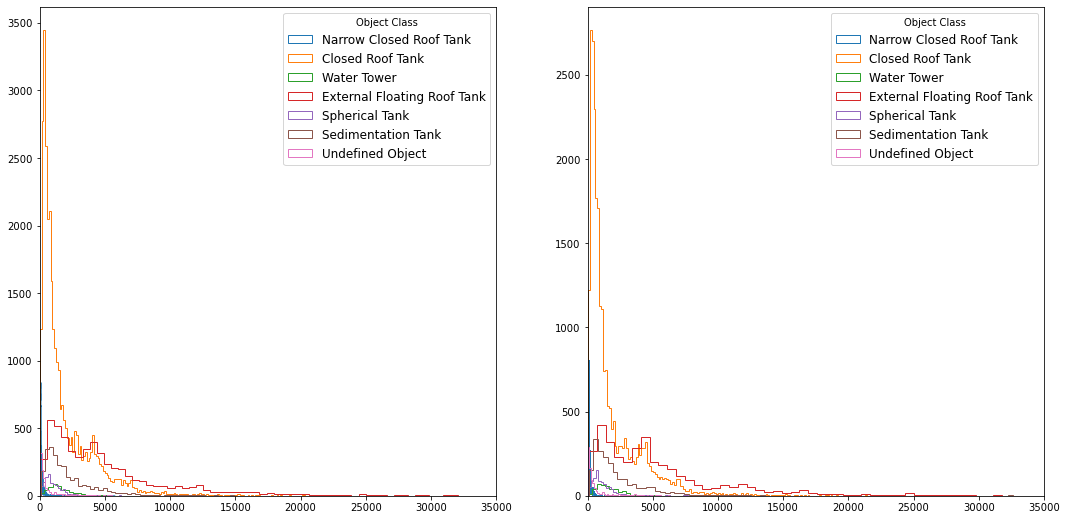

In [6]:
fig, axes = plt.subplots(1,2, figsize=(18,9))
counter = 0
for name, ax in zip(names, axes.flatten()):
    print(keep_difficult_input[counter], box_remove_input[counter])
    area_dict, area_sqrt_dict, aspect_ratio_dict = area_and_aspect_ratio(parent_dir, img_ids, anno_dir, keep_difficult = keep_difficult_input[counter], bbox_remove = box_remove_input[counter])
    # Draw the density plot
    #ax.set_xscale('log')
    ax.set_xlim(0,35000)
    ax.hist(area_dict["narrow_closed_roof_tank"],  bins='auto', stacked=True,fill=False,histtype='step', label = "Narrow Closed Roof Tank")
    ax.hist(area_dict["closed_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Closed Roof Tank")  
                           
    ax.hist(area_dict["water_tower"],  bins='auto', stacked=True, fill=False,  histtype='step' ,label = "Water Tower")  
                           
    ax.hist(area_dict["external_floating_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "External Floating Roof Tank") 
                           
    ax.hist(area_dict["spherical_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Spherical Tank") 
                           
    ax.hist(area_dict["sedimentation_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Sedimentation Tank")             
    ax.hist(area_dict["undefined_object"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Undefined Object")  
    # Plot formatting
    ax.legend(prop={'size': 12}, title = 'Object Class')
    counter += 1
plt.show()

True 0
False 0


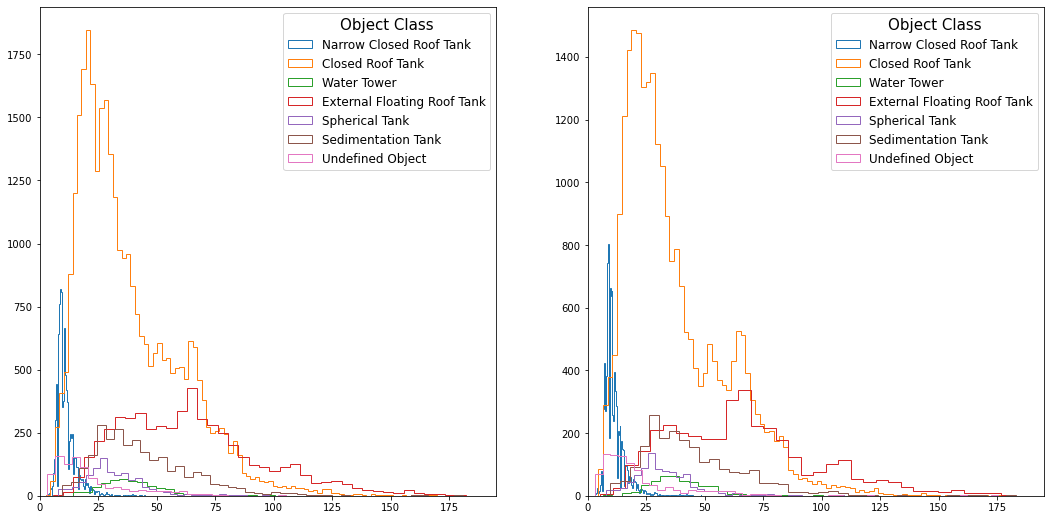

In [7]:
fig, axes = plt.subplots(1,2, figsize=(18,9))
counter = 0
for name, ax in zip(names, axes.flatten()):
    print(keep_difficult_input[counter], box_remove_input[counter])
    area_dict, area_sqrt_dict, aspect_ratio_dict = area_and_aspect_ratio(parent_dir, img_ids, anno_dir, keep_difficult = keep_difficult_input[counter], bbox_remove = box_remove_input[counter])
    # Draw the density plot
    #ax.set_xscale('log')
    ax.set_xlim(0,195)
    ax.hist(area_sqrt_dict["narrow_closed_roof_tank"],  bins='auto', stacked=True,fill=False,histtype='step', label = "Narrow Closed Roof Tank")
    ax.hist(area_sqrt_dict["closed_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Closed Roof Tank")  
                           
    ax.hist(area_sqrt_dict["water_tower"],  bins='auto', stacked=True, fill=False,  histtype='step' ,label = "Water Tower")  
                           
    ax.hist(area_sqrt_dict["external_floating_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "External Floating Roof Tank") 
                           
    ax.hist(area_sqrt_dict["spherical_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Spherical Tank") 
                           
    ax.hist(area_sqrt_dict["sedimentation_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Sedimentation Tank")             
    ax.hist(area_sqrt_dict["undefined_object"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Undefined Object")  
    # Plot formatting
    ax.legend(prop={'size': 12},fontsize=10, title_fontsize=15, title = 'Object Class')
    counter += 1
plt.show()

True 0


NameError: name 'aspect_ratio' is not defined

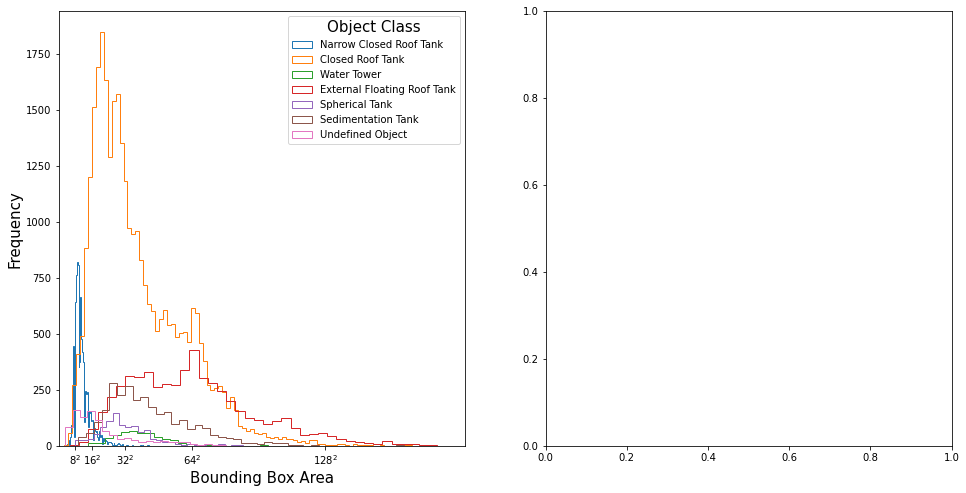

In [9]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

print(keep_difficult_input[counter], box_remove_input[counter])
area_dict, area_sqrt_dict, aspect_ratio_dict = area_and_aspect_ratio(parent_dir, img_ids, anno_dir, keep_difficult = keep_difficult_input[counter], bbox_remove = box_remove_input[counter])
#ax[0,0].set_xscale('log')
ax[0].hist(area_sqrt_dict["narrow_closed_roof_tank"],  bins='auto', stacked=True,fill=False,histtype='step', label = "Narrow Closed Roof Tank")
ax[0].hist(area_sqrt_dict["closed_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Closed Roof Tank")  
ax[0].hist(area_sqrt_dict["water_tower"],  bins='auto', stacked=True, fill=False,  histtype='step' ,label = "Water Tower")  
ax[0].hist(area_sqrt_dict["external_floating_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "External Floating Roof Tank") 
ax[0].hist(area_sqrt_dict["spherical_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Spherical Tank") 
ax[0].hist(area_sqrt_dict["sedimentation_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Sedimentation Tank")             
ax[0].hist(area_sqrt_dict["undefined_object"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Undefined Object")  
ax[0].legend(prop={'size': 10},fontsize=10, title_fontsize=15, title = 'Object Class')
ax[0].set_ylabel('Frequency', fontsize=15)
ax[0].set_xlim(0,195)
xticks = [8,16,32,64,128]
ax[0].set_xticks(xticks)
labels = ['$8^{2}$','$16^{2}$','$32^{2}$','$64^{2}$','$128^{2}$']
ax[0].set_xticklabels((labels), fontsize=10) 
ax[0].set_xlabel('Bounding Box Area', fontsize=15)

ax[1].hist(aspect_ratio["narrow_closed_roof_tank"],  bins='auto', stacked=True,fill=False,histtype='step', label = "Narrow Closed Roof Tank")
ax[1].hist(aspect_ratio["closed_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Closed Roof Tank")                           
ax[1].hist(aspect_ratio["water_tower"],  bins='auto', stacked=True, fill=False,  histtype='step' ,label = "Water Tower")                           
ax[1].hist(aspect_ratio["external_floating_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "External Floating Roof Tank")                         
ax[1].hist(aspect_ratio["spherical_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Spherical Tank")                          
ax[1].hist(aspect_ratio["sedimentation_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Sedimentation Tank")             
ax[1].hist(aspect_ratio["undefined_object"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Undefined Object")  
ax[1].legend(prop={'size': 10},fontsize=10, title_fontsize=15, title = 'Object Class')
ax[1].set_ylabel('Frequency', fontsize=15)
ax[1].set_xlim(0,3)
xticks = [0.5,1,2,3]
ax[1].set_xticks(xticks)
labels = ['1:2','1:1','2:1','3:1']
ax[1].set_xticklabels((labels), fontsize=10) 
ax[1].set_xlabel('Aspect Ratio', fontsize=15)

# Plot formatting
plt.suptitle('Bounding Box Characteristics', fontsize= 30)
#plt.show()
plt.savefig('bounding_box_characteristics.png', transparent=True)

In [ ]:
area_dict, area_sqrt_dict, aspect_ratio_dict = area_and_aspect_ratio(parent_dir, img_ids, anno_dir, 
                                                                     keep_difficult = True, 
                                                                     bbox_remove = 0)

Dataframe of the Objects quared Area (Including Truncated/Difficult Objects)

In [ ]:
area_dict, area_sqrt_dict, aspect_ratio_dict = area_and_aspect_ratio(parent_dir, img_ids, anno_dir, 
                                                                     keep_difficult = True, 
                                                                     bbox_remove = 0)

In [ ]:
class_stats = []
class_ = []
for x in area_sqrt_dict:
    class_.append(x)
    class_stats.append([statistics.mean(area_sqrt_dict[x]), np.quantile(area_sqrt_dict[x], 0.05),
                        np.quantile(area_sqrt_dict[x],0.1), np.quantile(area_sqrt_dict[x],0.2),
                        np.quantile(area_sqrt_dict[x],0.5), np.quantile(area_sqrt_dict[x],0.95), len(area_sqrt_dict[x])])
class_stats = np.array(class_stats)

class_stats_df = pd.DataFrame(class_stats, columns = ['mean', '0.05 quantile', '0.1 quantile',
                                                      '0.2 quantile', '0.5 quantile',
                                                      '0.95 quantile', "number of objects"])
class_stats_df.insert(0, "class", class_, True)
class_stats_df

Dataframe of the Objects squared Area (Excluding Truncated/Difficult Objects)

In [ ]:
area_dict, area_sqrt_dict, aspect_ratio_dict = area_and_aspect_ratio(parent_dir, img_ids, anno_dir, 
                                                                     keep_difficult = False, 
                                                                     bbox_remove = 0)

In [ ]:
class_stats = []
class_ = []
for x in area_sqrt_dict:
    class_.append(x)
    class_stats.append([statistics.mean(area_sqrt_dict[x]), np.quantile(area_sqrt_dict[x], 0.05),
                        np.quantile(area_sqrt_dict[x],0.5), np.quantile(area_sqrt_dict[x],0.95), len(area_sqrt_dict[x])])
class_stats = np.array(class_stats)

class_stats_df = pd.DataFrame(class_stats, columns = ['mean', '0.05 quantile', '0.5 quantile', '0.95 quantile', "number of objects"])
class_stats_df.insert(0, "class", class_, True)
class_stats_df

In [ ]:
        self.areaRng = [[0 ** 2, 1e5 ** 2], [0 ** 2, 32 ** 2], [32 ** 2, 96 ** 2], [96 ** 2, 1e5 ** 2]]
        self.areaRngLbl = ['all', 'small', 'medium', 'large']

In [ ]:
# Find IDs of images for subset
keep_difficult_input = [True,False,False,False]
box_remove_input = [1,1,10,20]

names = ['Keep difficult objects and all objects', "Remove difficult objects", 
         "Remove difficult objects and bounding boxes less than 10**2 in area", "Remove difficult objects and bounding boxes 20**2"]

fig, axes = plt.subplots(2,2, figsize=(18,18))
counter = 0
for name, ax in zip(names, axes.flatten()):
    print(keep_difficult_input[counter], box_remove_input[counter])
    area_dict, aspect_ratio_dict = area_and_aspect_ratio(parent_dir, img_ids, anno_dir, keep_difficult = keep_difficult_input[counter], bbox_remove = box_remove_input[counter])
    # Draw the density plot
    ax.set_xscale('log')
    ax.set_xlim(0,100000)
    print(min(area_dict["undefined_object"]))
    ax.hist(area_dict["narrow_closed_roof_tank"],  bins='auto', stacked=True,fill=False,histtype='step', label = "Narrow Closed Roof Tank")
    ax.hist(area_dict["closed_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Closed Roof Tank")  
                           
    ax.hist(area_dict["water_tower"],  bins='auto', stacked=True, fill=False,  histtype='step' ,label = "Water Tower")  
                           
    ax.hist(area_dict["external_floating_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "External Floating Roof Tank") 
                           
    ax.hist(area_dict["spherical_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Spherical Tank") 
                           
    ax.hist(area_dict["sedimentation_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Sedimentation Tank")             
    ax.hist(area_dict["undefined_object"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Undefined Object")  
    # Plot formatting
    ax.legend(prop={'size': 8}, title = 'Airline')
    counter += 1
plt.show()